# 3. Analyzing TAD conservation with BLAST

# Strategy 3
## Detecting conserved TADs with SVs
## Not detecting split/merge events
### Finding % identity of NPB TADs in Azucena
1. Blasting all NPB TADs to azucena TADs with no min perc_ident or alignment rate, -max_target_seqs 1
2. Extracting all hits per TAD (1 TAD - 1 target), summarizing, recording query coverage
3. Identifying average/median query_cov, plotting their distribution

In [1]:
#1. Extracting TAD sequences to x_tads.fna
module load bedtools/intel/2.29.2
bedtools getfasta -fi ../genomes/NPB.fna -bed ../comparative_TADs_boundaries/NPB_TADs_ranked.bed -fo npb_tads.fna
bedtools getfasta -fi ../genomes/azucena.fna -bed ../comparative_TADs_boundaries/az_TADs_5kb_two_tools_80.bed -fo az_tads.fna
bedtools getfasta -fi ../genomes/IR64.fna -bed ../comparative_TADs_boundaries/IR64_TADs_5kb_two_tools_80.bed -fo ir64_tads.fna
bedtools getfasta -fi ../genomes/orufi.fna -bed ../comparative_TADs_boundaries/oruf_TADs_5kb_two_tools_80.bed -fo oruf_tads.fna
bedtools getfasta -fi ../genomes/omer.fna -bed ../comparative_TADs_boundaries/omer_TADs_5kb_two_tools_80.bed -fo omer_tads.fna

index file ../genomes/azucena.fna.fai not found, generating...
index file ../genomes/IR64.fna.fai not found, generating...
index file ../genomes/orufi.fna.fai not found, generating...
index file ../genomes/omer.fna.fai not found, generating...


In [12]:
#2. npb_az_all_blast_results3.txt
#query = npb
#targets = az,ir64,oruf,omer
sbatch blast.sh

Submitted batch job 40432982


In [9]:
#3
#output file structure: npb_TAD identifier, cumulative query coverage by subject, az_TAD identifier

# Define the input and output file names
blast_output_file = 'npb_omer_all_blast_results3.txt'
output_file = 'npb_omer_query_cov3.txt'

# Create a dictionary to store the cumulative query coverage and col2 for each unique identifier in column 1
query_coverage_dict = {}

# Open the BLAST output file and process each line
with open(blast_output_file, 'r') as blast_file:
    for line in blast_file:
        # Split the line into parts based on tab delimiter
        parts = line.strip().split('\t')

        # Extract values from the line
        blast_string = parts[0]
        hsp_length = int(parts[3])
        query_length = int(parts[-1])
        col2 = parts[1]

        # Calculate query coverage per HSP
        query_coverage = (hsp_length / query_length) * 100

        # Check if the identifier is already in the dictionary
        if blast_string in query_coverage_dict:
            # Update cumulative query coverage and col2
            query_coverage_dict[blast_string]['cumulative_coverage'] += query_coverage
            query_coverage_dict[blast_string]['col2'] = col2
        else:
            # If not, add the identifier to the dictionary
            query_coverage_dict[blast_string] = {'cumulative_coverage': query_coverage, 'col2': col2}

# Open the output file and write the results
with open(output_file, 'w') as output:
    for identifier, values in query_coverage_dict.items():
        # Get cumulative query coverage and col2
        cumulative_query_coverage = values['cumulative_coverage']
        col2_value = values['col2']
        # Write results to the output file
        output.write(f'{identifier}\t{cumulative_query_coverage:.2f}\t{col2_value}\n')

In [3]:
#find how many npb TADs blasted to az tads from the same chromosome
#number of such tads = conserved+complex_rearrangements+splits+merges
with open('npb_omer_query_cov3.txt', 'r') as input_file:
    lines = input_file.readlines()

matching_lines = [line for line in lines if line.split('\t')[0].split(':')[0] == line.split('\t')[2].split(':')[0]]

with open('npb_omer_cons_rearr.txt', 'w') as output_file:
    output_file.writelines(matching_lines)

In [ ]:
import statistics

# Read the file and extract coverage values
coverage_values = []
with open('npb_omer_query_cov3.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        coverage = float(parts[1])
        coverage_values.append(coverage)

# Calculate the average and median values
average_coverage = statistics.mean(coverage_values)
median_coverage = statistics.median(coverage_values)

# Print the results
print(f'Average Coverage: {average_coverage:.2f}')
print(f'Median Coverage: {median_coverage:.2f}')

# Plot distributions of query_coverages for TADs conserved between NPB-X

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

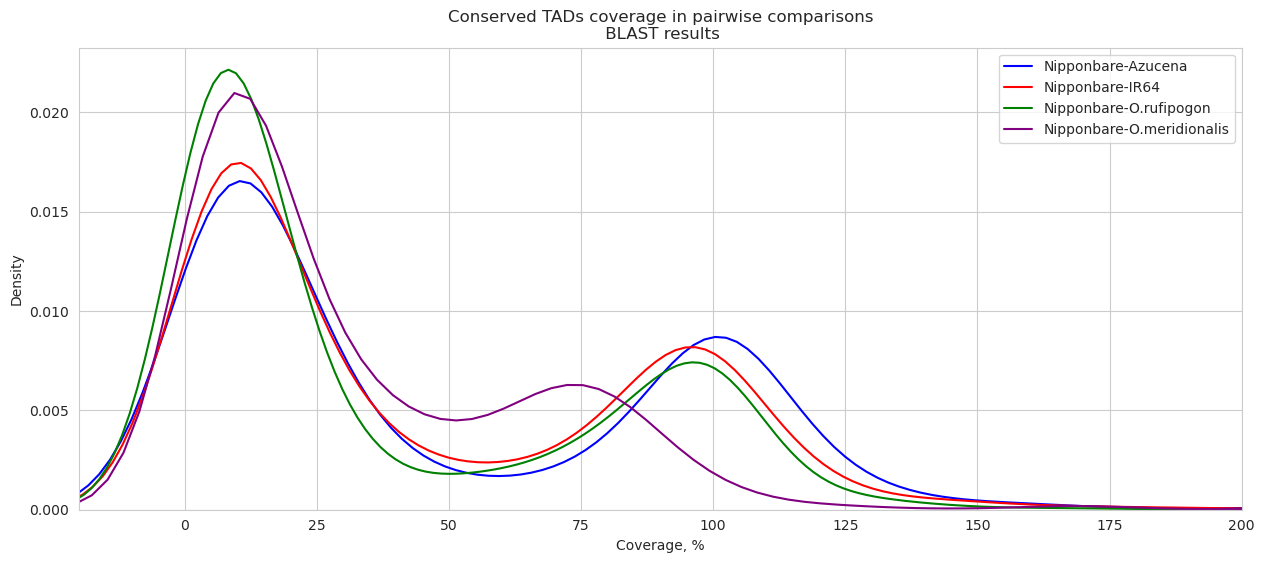

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of file names
file_names = [
    'npb_az_query_cov3.txt',
    'npb_ir64_query_cov3.txt',
    'npb_oruf_query_cov3.txt',
    'npb_omer_query_cov3.txt'
]

# List of color names
colors = ['blue', 'red', 'green', 'purple']

# List of custom legend labels
labels = ['Nipponbare-Azucena', 'Nipponbare-IR64', 'Nipponbare-O.rufipogon', 'Nipponbare-O.meridionalis']

# Set the style for the plot
sns.set_style("whitegrid")

# Create subplots to plot all KDE plots on the same graph
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each file and plot KDE with custom color and label
for file_name, color, label in zip(file_names, colors, labels):
    # Read the data from the file
    data = pd.read_csv(file_name, sep='\t', header=None, names=['col1', 'col2', 'col3'])
    
    # Create a KDE plot for column 2 with custom color and label
    sns.kdeplot(data=data, x='col2', ax=ax, color=color, label=label)

# Set x-axis limits
ax.set_xlim(-20, 200)  # Set minimum limit to 0 and maximum limit to 200

# Add labels and a legend
plt.xlabel('Coverage, %')
plt.title('Conserved TADs coverage in pairwise comparisons\n BLAST results')
plt.ylabel('Density')
plt.legend()
plt.savefig('/scratch/ak8725/figs/figS9B.pdf')

# Show the plot
plt.show()

### Plotting only TADs with coverage >= 50%

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

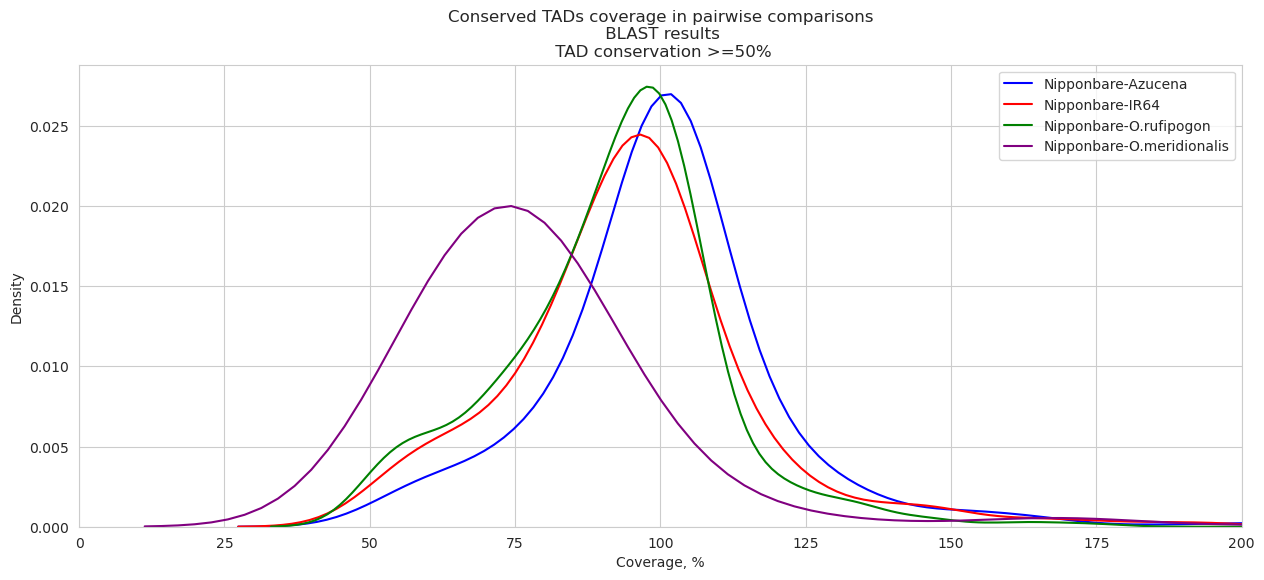

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of file names
file_names = [
    'npb_az_query_cov3.txt',
    'npb_ir64_query_cov3.txt',
    'npb_oruf_query_cov3.txt',
    'npb_omer_query_cov3.txt'
]

# List of color names
colors = ['blue', 'red', 'green', 'purple']

# List of custom legend labels
labels = ['Nipponbare-Azucena', 'Nipponbare-IR64', 'Nipponbare-O.rufipogon', 'Nipponbare-O.meridionalis']

# Set the style for the plot
sns.set_style("whitegrid")

# Create subplots to plot all KDE plots on the same graph
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through each file and plot KDE with custom color and label
for file_name, color, label in zip(file_names, colors, labels):
    # Read the data from the file
    data = pd.read_csv(file_name, sep='\t', header=None, names=['col1', 'col2', 'col3'])
    
    # Filter data where col2 is greater than or equal to 50
    data_filtered = data[data['col2'] >= 50]
    
    # Create a KDE plot for column 2 with custom color and label
    sns.kdeplot(data=data_filtered, x='col2', ax=ax, color=color, label=label)

# Set x-axis limits
ax.set_xlim(0, 200)  # Set minimum limit to 0 and maximum limit to 200

# Add labels and a legend
plt.xlabel('Coverage, %')
plt.title('Conserved TADs coverage in pairwise comparisons\n BLAST results\n TAD conservation >=50%')
plt.ylabel('Density')
plt.legend()
plt.savefig('/scratch/ak8725/figs/figS9C.pdf')

# Show the plot
plt.show()

### How many TADs are conserved >=50% in pairwise comparisons?

In [12]:
import pandas as pd

# Dictionary mapping aliases to file names
file_aliases = {
    'Nipponbare-Azucena': 'npb_az_query_cov3.txt',
    'Nipponbare-IR64': 'npb_ir64_query_cov3.txt',
    'Nipponbare-O.rufipogon': 'npb_oruf_query_cov3.txt',
    'Nipponbare-O.meridionalis': 'npb_omer_query_cov3.txt'
}

for alias, file_name in file_aliases.items():
    print(alias)
    
    # Read the data from the file
    data = pd.read_csv(file_name, sep='\t', header=None, names=['region', 'coverage', 'target_region'])

    # Calculate and print mean coverage
    mean_coverage = data['coverage'].mean()
    print(f"Mean coverage: {mean_coverage:.2f}")

    # Calculate and print median coverage
    median_coverage = data['coverage'].median()
    print(f"Median coverage: {median_coverage:.2f}")

    # Calculate and print total number of rows
    total_rows = len(data)
    print(f"Total rows: {total_rows}")

    # Calculate and print proportion of rows with coverage >= 50, 80, 90, 100
    coverage_above_50 = data[data['coverage'] >= 50]
    proportion_above_50 = len(coverage_above_50) / total_rows * 100
    print(f"Coverage >= 50: {proportion_above_50:.2f}")
    coverage_above_80 = data[data['coverage'] >= 80]
    proportion_above_80 = len(coverage_above_80) / total_rows * 100
    print(f"Coverage >= 80: {proportion_above_80:.2f}")
    coverage_above_90 = data[data['coverage'] >= 90]
    proportion_above_90 = len(coverage_above_90) / total_rows * 100
    print(f"Coverage >= 90: {proportion_above_90:.2f}")
    coverage_above_100 = data[data['coverage'] >= 100]
    proportion_above_100 = len(coverage_above_100) / total_rows * 100
    print(f"Coverage >= 100: {proportion_above_100:.2f}%\n")
    
    # Calculate and print number of rows with coverage >= 50, 80, 90, 100
    print(f"Coverage >= 50: {len(coverage_above_50)} TADs")
    print(f"Coverage >= 80: {len(coverage_above_80)} TADs")
    print(f"Coverage >= 90: {len(coverage_above_90)} TADs")
    print(f"Coverage >= 100: {len(coverage_above_100)} TADs\n")

Nipponbare-Azucena
Mean coverage: 48.40
Median coverage: 23.45
Total rows: 1425
Coverage >= 50: 38.95
Coverage >= 80: 34.11
Coverage >= 90: 30.74
Coverage >= 100: 21.40%

Coverage >= 50: 555 TADs
Coverage >= 80: 486 TADs
Coverage >= 90: 438 TADs
Coverage >= 100: 305 TADs

Nipponbare-IR64
Mean coverage: 45.50
Median coverage: 23.15
Total rows: 1425
Coverage >= 50: 38.11
Coverage >= 80: 30.95
Coverage >= 90: 24.49
Coverage >= 100: 13.61%

Coverage >= 50: 543 TADs
Coverage >= 80: 441 TADs
Coverage >= 90: 349 TADs
Coverage >= 100: 194 TADs

Nipponbare-O.rufipogon
Mean coverage: 37.40
Median coverage: 14.60
Total rows: 1425
Coverage >= 50: 32.49
Coverage >= 80: 24.91
Coverage >= 90: 19.37
Coverage >= 100: 10.53%

Coverage >= 50: 463 TADs
Coverage >= 80: 355 TADs
Coverage >= 90: 276 TADs
Coverage >= 100: 150 TADs

Nipponbare-O.meridionalis
Mean coverage: 33.75
Median coverage: 18.64
Total rows: 1425
Coverage >= 50: 27.44
Coverage >= 80: 10.18
Coverage >= 90: 4.56
Coverage >= 100: 2.67%

Cove

In [ ]:
# For comparison. When I used conserved TAD identification by liftover (blast values in parenthesis):
#percentage of TADs conserved between pairs, at least 80% feature overlap
NPB-az: 27.93 (34.11)
NPB-IR64: 26.32 (30.95)
NPB-ruf: 21.26 (24.91)
NPB-omer: 13.75 (10.18)

#percentage of TADs conserved between pairs, at least 50% feature overlap
NPB-az: 34.18 (38.95)
NPB-IR64: 33.54 (38.11)
NPB-ruf: 29.33 (32.49)
NPB-omer: 24.56 (27.44)

In [7]:
# Calculate and print number of rows with coverage >= 50, 80, 90, 100
print(f"Coverage >= 50: {len(coverage_above_50)}")
print(f"Coverage >= 80: {len(coverage_above_80)}")
print(f"Coverage >= 90: {len(coverage_above_90)}")
print(f"Coverage >= 100: {len(coverage_above_100)}")

Coverage >= 50: 391
Coverage >= 80: 145
Coverage >= 90: 65
Coverage >= 100: 38


# Conserved TADs (more or = 50% conserved)

In [5]:
#identifying conserved tads
input_file_path = 'npb_omer_query_cov3.txt'
output_file_path = 'npb_omer_conserved.txt'

with open(input_file_path, 'r') as input_file:
    with open(output_file_path, 'w') as output_file:
        for line in input_file:
            # Split the line into columns
            columns = line.strip().split('\t')
            
            # Check the condition on col2
            if float(columns[1]) >= 50:
                # Write the row to the output file
                output_file.write(line)

In [12]:
#creating bed file with conserved tads
input_file = 'npb_omer_conserved.txt'
output_file = 'npb_omer_conserved.bed'

with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    # Iterate over each line in the input file
    for line in infile:
        # Split the line into columns
        columns = line.strip().split('\t')

        # Extract chr, start, and end from col1
        chr_info = columns[0].split(':')
        start, end = chr_info[1].split('-')

        # Write the three columns to the output file
        outfile.write(f"{chr_info[0]}\t{start}\t{end}\n")